[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [18]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [19]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [20]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [21]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"What topic are you exploring today?", name="Bot")]
messages.append(HumanMessage(f"I'm curious about T20 cricket strategies. Can you explain key bowling tactics?", name="Akshit"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

What topic are you exploring today?
================================ Human Message =================================
Name: Akshit

I'm curious about T20 cricket strategies. Can you explain key bowling tactics?


Recall we can pass them to a chat model.

In [22]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Certainly! In T20 cricket, bowling strategies are crucial given the fast-paced and high-scoring nature of the game. Here are some key bowling tactics used in T20 cricket:\n\n1. **Variation in Pace and Length**: Bowlers frequently vary their pace and length to keep batsmen guessing. Slower balls, yorkers, and occasional bouncers are mixed up to disrupt the batter\'s rhythm.\n\n2. **Yorkers and Wide Yorkers**: Perfectly executed yorkers are hard to score from, especially in the death overs. Bowlers aim for the base of the stumps or slightly outside the off-stump to limit scoring opportunities.\n\n3. **Slower Balls and Off-Cutters**: Slower deliveries, including off-cutters and leg-cutters, are used to deceive batsmen expecting a faster delivery, making it harder for them to time their shots.\n\n4. **Bouncers and Short Balls**: Used sparingly, bouncers can surprise batsmen and potentially lead to a false shot. Short balls are also used to push the batsman back and creat

We can run our chat model in a simple graph with `MessagesState`.

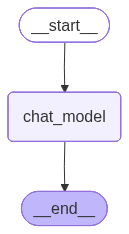

In [23]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

What topic are you exploring today?
================================ Human Message =================================
Name: Akshit

I'm curious about T20 cricket strategies. Can you explain key bowling tactics?
================================== Ai Message ==================================

Certainly! In T20 cricket, the fast-paced nature of the game influences a variety of bowling strategies aimed at containing runs and taking wickets. Here are some key bowling tactics used in T20 cricket:

1. **Yorkers**: Delivering yorkers, which are full-length deliveries that aim at the batsman's toes, can be very effective in restricting scoring opportunities and making it difficult for batsmen to hit boundaries, especially during the death overs.

2. **Variations and Slower Balls**: Using variations such as slower balls, off-cutters, leg-cutters, and back-of-the-hand deliveries can deceive batsmen who are

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

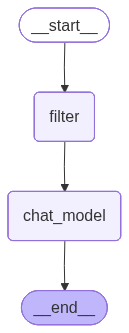

In [25]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Akshit", id="2"))
messages.append(AIMessage("So you said you were exploring T20 cricket strategies?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know batting basics. What bowling strategies should I learn?", name="Akshit", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were exploring T20 cricket strategies?
================================ Human Message =================================
Name: Akshit

Yes, I know batting basics. What bowling strategies should I learn?
================================== Ai Message ==================================

In T20 cricket, effective bowling can often make the difference between winning and losing. Here are some key bowling strategies you should consider learning and practicing:

1. **Variety in Pace:**
   - Varying your pace can disrupt the batsman’s timing. Bowlers often alternate between slower balls, medium pace, and their quicker deliveries to confuse batsmen.

2. **Yorkers:**
   - A well-executed yorker (a delivery pitched at the batsman's feet) is difficult to hit and is especially effective in the death overs (final overs of the innings).

3. **Short Balls and Bouncers:**
   - Use bouncers strateg

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

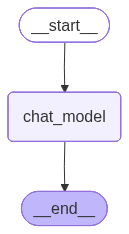

In [27]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [28]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about death-overs bowling and Yorkers!", name="Akshit"))

In [29]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Akshit

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were exploring T20 cricket strategies?
================================ Human Message =================================
Name: Akshit

Yes, I know batting basics. What bowling strategies should I learn?
================================== Ai Message ==================================

In T20 cricket, effective bowling can often make the difference between winning and losing. Here are some key bowling strategies you should consider learning and practicing:

1. **Variety in Pace:**
   - Varying your pace can disrupt the batsman’s timing. Bowlers often alternate between slower balls, medium pace, and their quicker deliveries to confuse batsmen.

2. **Yorkers:**
   - A well-executed yorker (a d

In [30]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Akshit

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were exploring T20 cricket strategies?
================================ Human Message =================================
Name: Akshit

Yes, I know batting basics. What bowling strategies should I learn?
================================== Ai Message ==================================

In T20 cricket, effective bowling can often make the difference between winning and losing. Here are some key bowling strategies you should consider learning and practicing:

1. **Variety in Pace:**
   - Varying your pace can disrupt the batsman’s timing. Bowlers often alternate between slower balls, medium pace, and their quicker deliveries to confuse batsmen.

2. **Yorkers:**
   - A well-executed yorker (a d

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

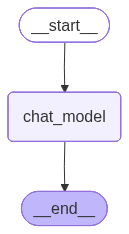

In [31]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Where is the next ICC Cricket World Cup being hosted?", name="Akshit"))

In [33]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Where is the next ICC Cricket World Cup being hosted?', additional_kwargs={}, response_metadata={}, name='Akshit')]

In [34]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

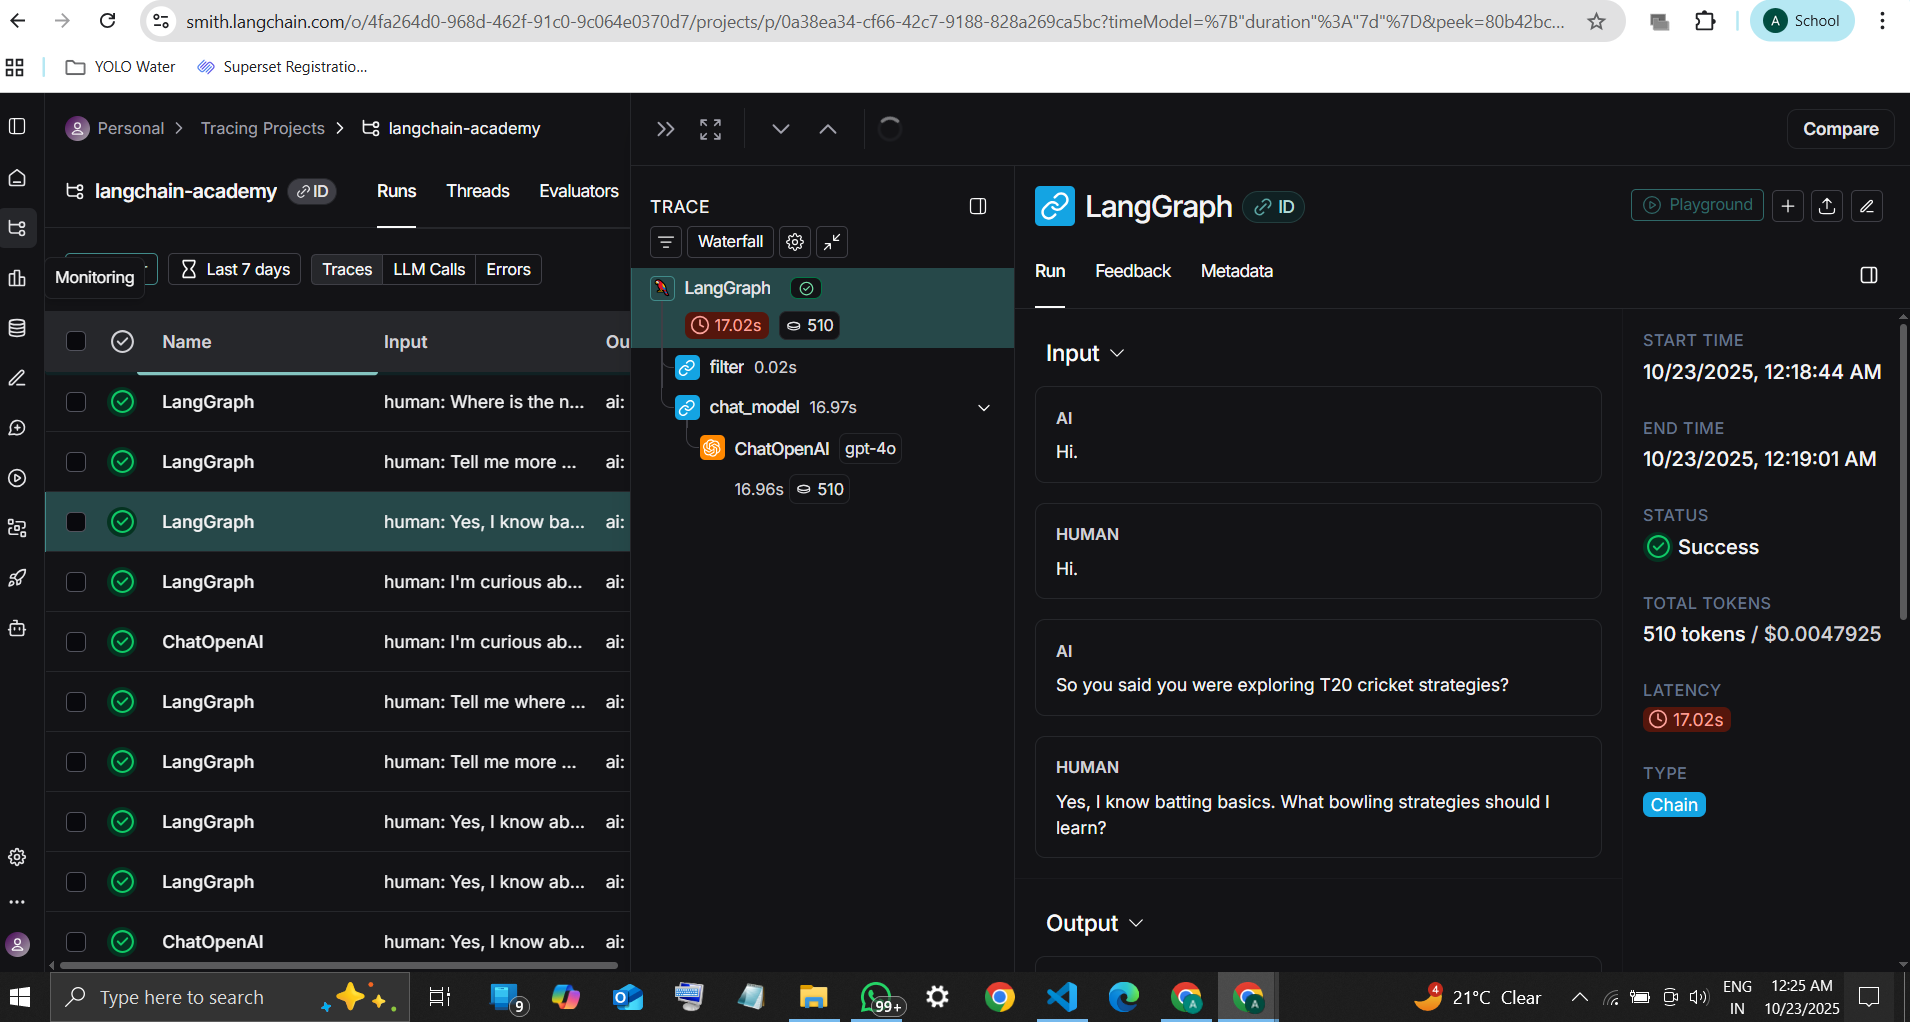

https://smith.langchain.com/public/22dc29b0-6411-48f3-9caf-e3333b2ceba7/r

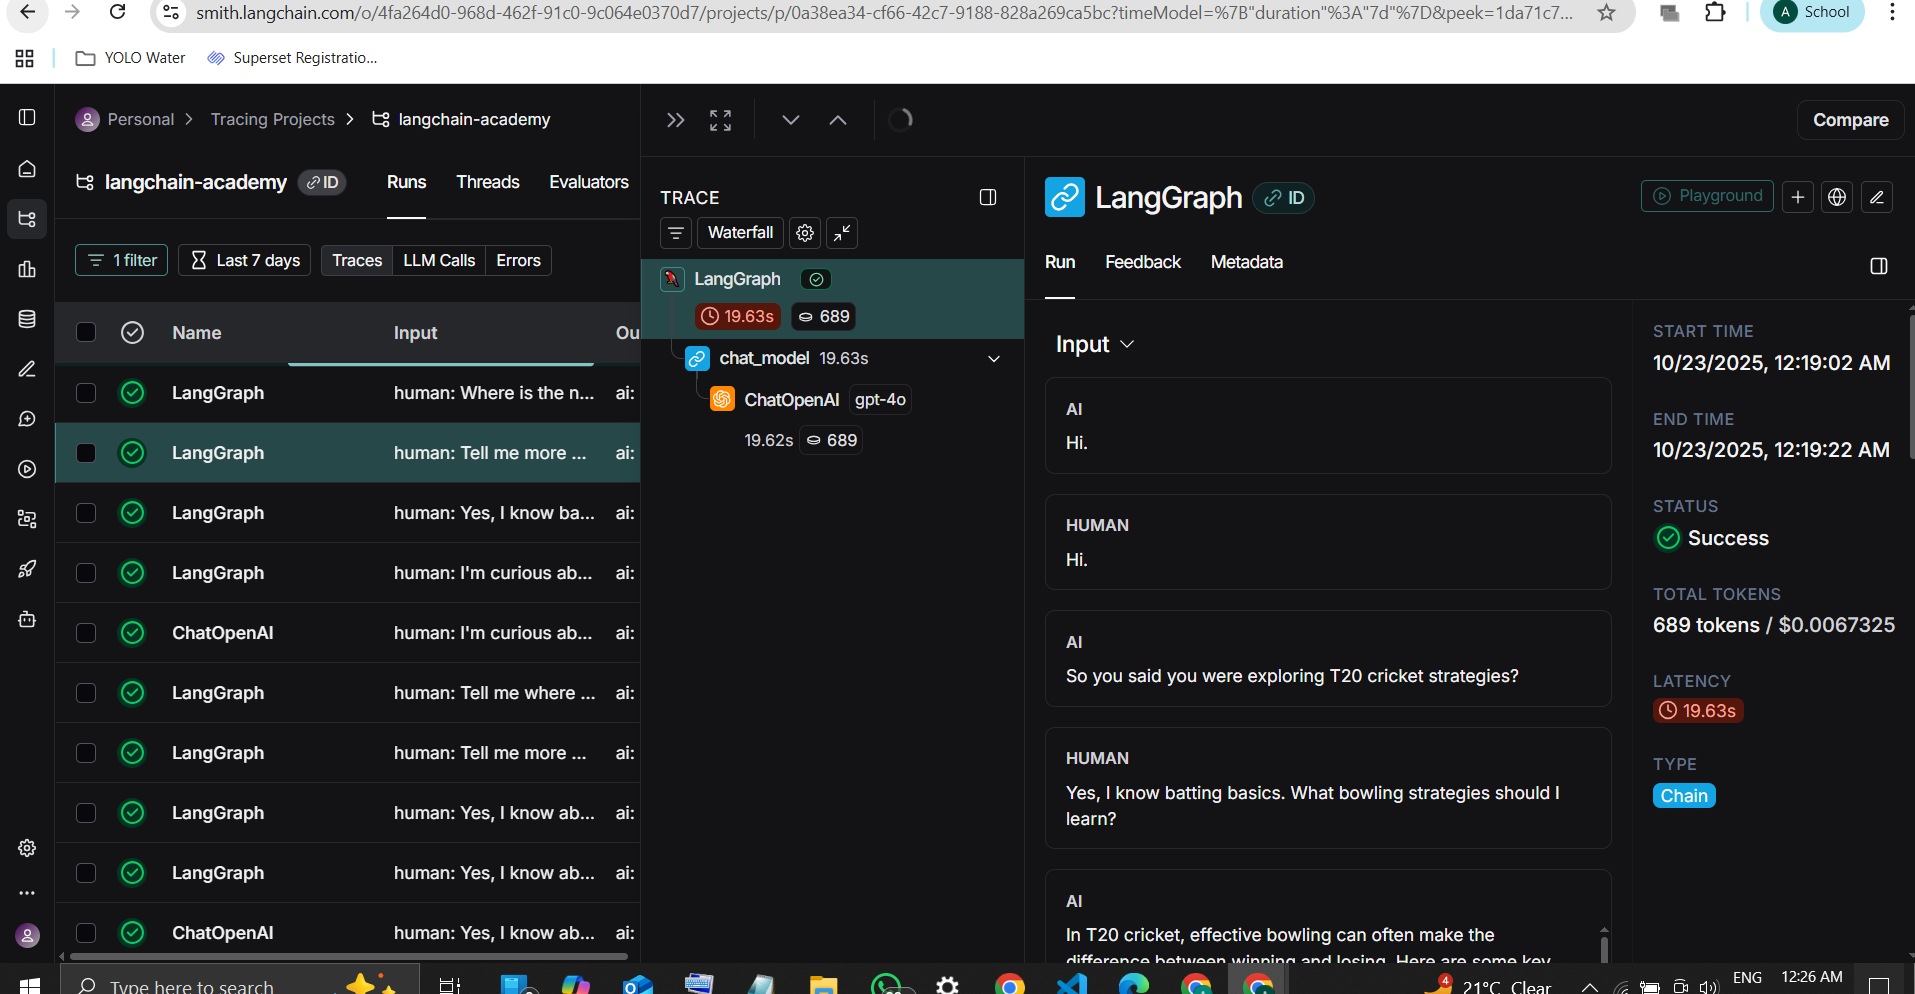

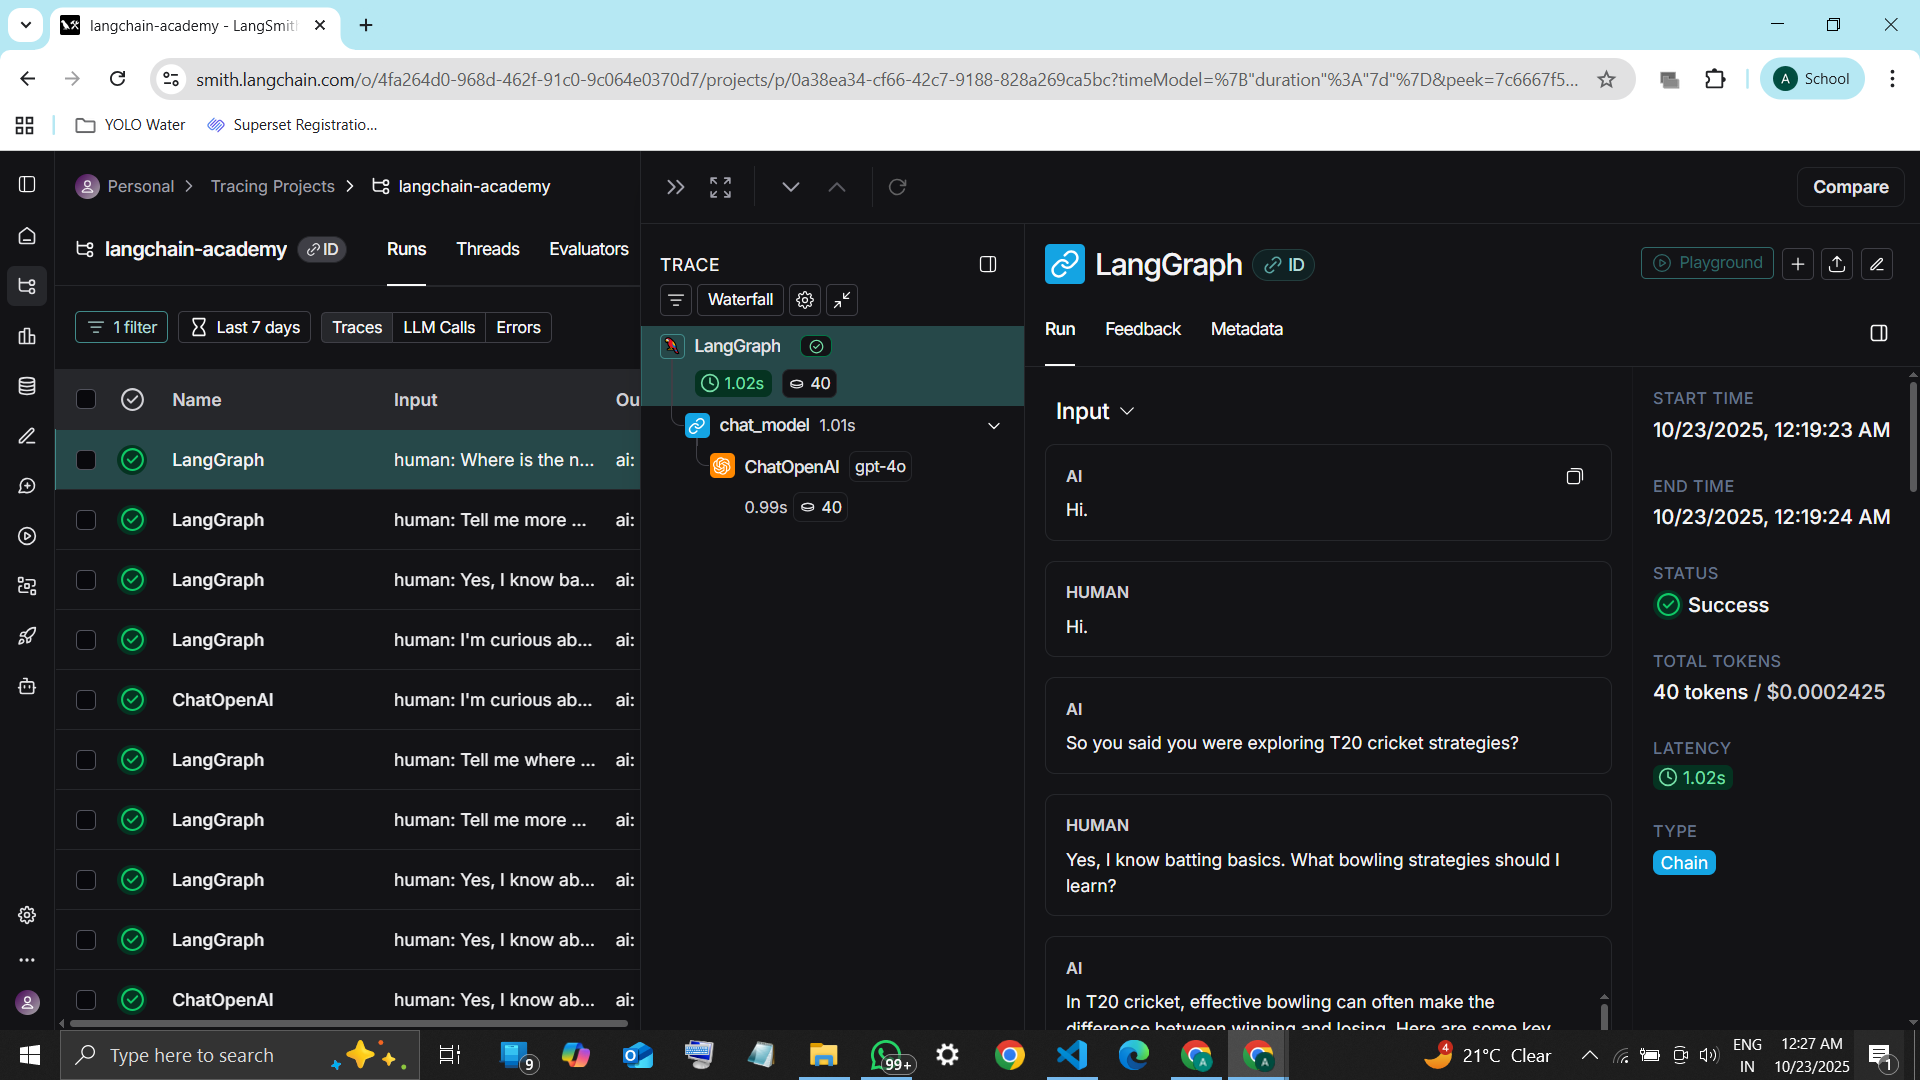

https://smith.langchain.com/public/e9c63fa6-8e79-49f5-8121-15060b132845/r